In [31]:
#Final H5file creator
import os, sys
from glob import glob
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=False)
import json
from tqdm.notebook import tqdm
import h5py
from feature_engine.discretisation import DecisionTreeDiscretiser
import re

sys.path.insert(0, "../dataloaders/UKBB/")
from ukbb2020_dataloader import UKBB2020

sys.path.insert(0, "../helper/")
from plotGraphs import *

In [32]:
dataset = UKBB2020()

total subjects in df: 40682


In [33]:
df = dataset.get_metadata(predefined=[], cols = ["31-0.0", #sex
                                                '54-2.0', #assestment center
                                                 '21003-2.0', #age
                                                 '1707-0.0',#handedness
                                                 '21000-0.0',#ethenic background binary 
                                                 '6142-2.0', #current employment status
                                                  '738-2.0',#avarage household total income after tax
                                                 "709-2.0", #Household size 
                                                 '2178-2.0', #Overall health rating
                                                 '26521-2.0', #total brain volume
                                                 "1558-2.0",#Alc int freq
                                                 "26414-0.0", #Education Score
                                                 "20016-2.0", #Fluid Intelligence
                                                 "1239-2.0", #Actual Tobacco smoking
                                                 "6350-2.0", #Duration to complete alphanumeric path trial 1
                                                 "6348-2.0", #Duration to complete alphanumeric path trial 2
                                                 "5832-2.0", #Which eye has hypermetrophia
                                                 "20414-0.0","20403-0.0","20416-0.0",  # AUDIT
                                                 "6148-2.0", #Eye problem/disorders
                                                ],split='train', rename_cols=True)  

loaded following columns:
 {'31-0.0': 'Sex (s0.0)', '54-2.0': 'UK Biobank assessment centre', '21003-2.0': 'Age when attended assessment centre', '1707-0.0': 'Handedness (chirality/laterality) (s0.0)', '21000-0.0': 'Ethnic background (s0.0)', '6142-2.0': 'Current employment status', '738-2.0': 'Average total household income before tax', '709-2.0': 'Number in household', '2178-2.0': 'Overall health rating', '26521-2.0': 'Volume of EstimatedTotalIntraCranial (whole brain)', '1558-2.0': 'Alcohol intake frequency.', '26414-0.0': 'Education score (England) (s0.0)', '20016-2.0': 'Fluid intelligence score', '1239-2.0': 'Current tobacco smoking', '6350-2.0': 'Duration to complete alphanumeric path (trail #2)', '6348-2.0': 'Duration to complete numeric path (trail #1)', '5832-2.0': 'Which eye(s) affected by hypermetropia (long sight)', '20414-0.0': 'Frequency of drinking alcohol (s0.0)', '20403-0.0': 'Amount of alcohol drunk on a typical drinking day (s0.0)', '20416-0.0': 'Frequency of consumi

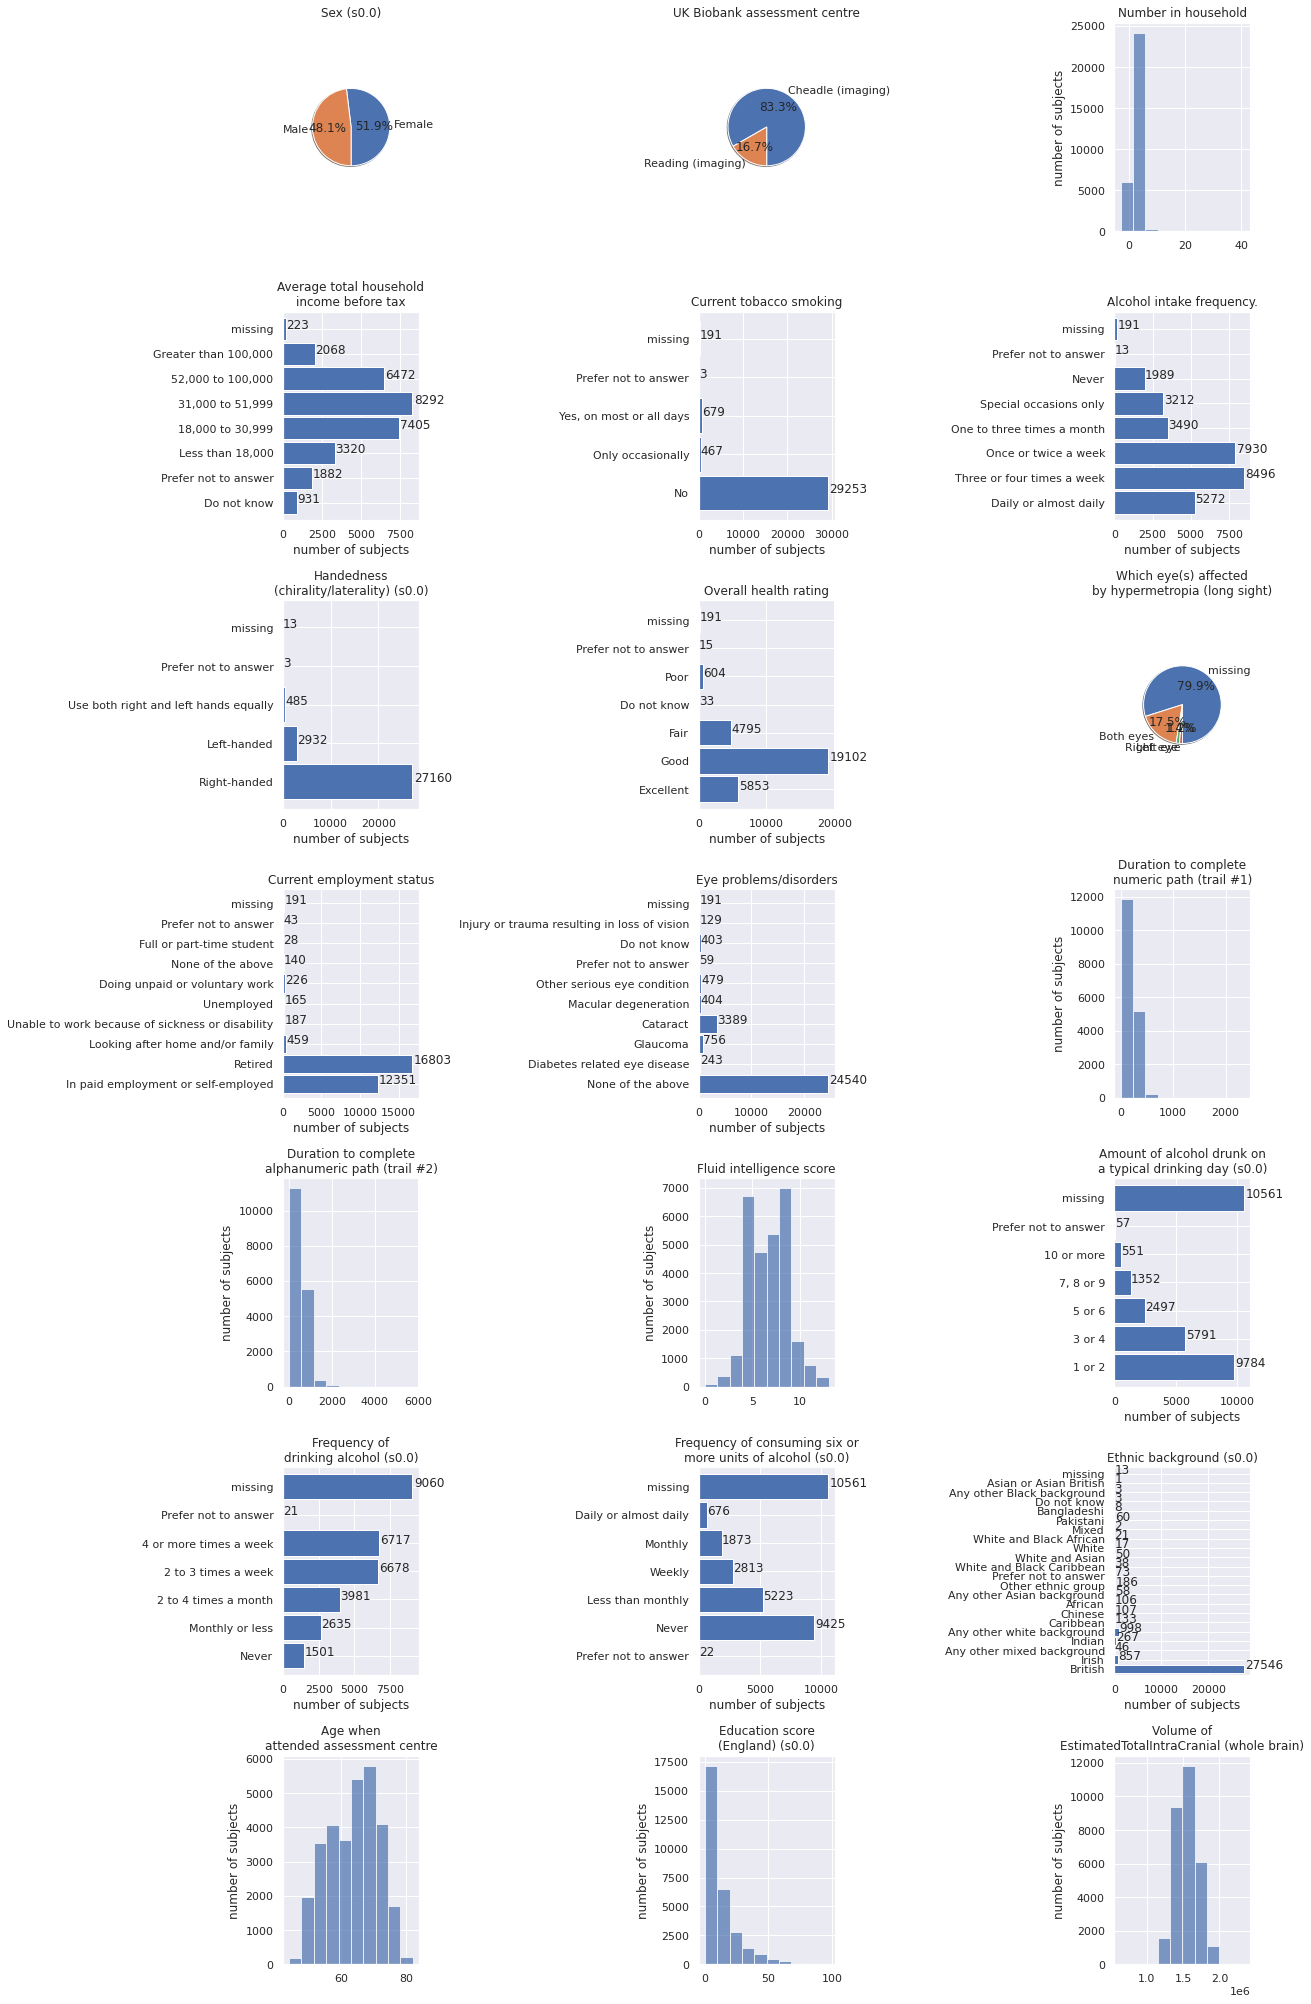

In [34]:
dataset.plot_metadata(df)

In [35]:
df = dataset.get_metadata(predefined=[], cols = ["31-0.0", #sex
                                                '54-2.0', #assestment center
                                                 '21003-2.0', #age
                                                 '1707-0.0',#handedness
                                                 '21000-0.0',#ethenic background binary 
                                                 '6142-2.0', #current employment status
                                                '738-2.0',#avarage household total income after tax
                                                 "709-2.0", #Household size 
                                                 '2178-2.0', #Overall health rating
                                                 '26521-2.0', #total brain volume
                                                 "1558-2.0",#Alc int freq
                                                 "26414-0.0", #Education Score
                                                 "20016-2.0", #Fluid Intelligence
                                                 "1239-2.0", #Actual Tobacco smoking
                                                 "6350-2.0", #Duration to complete alphanumeric path trial 1
                                                 "6348-2.0", #Duration to complete alphanumeric path trial 2
                                                "5832-2.0", #Which eye has hypermetrophia
                                                 "20414-0.0","20403-0.0","20416-0.0",  # AUDIT
                                                 "6148-2.0", #Eye problem/disorders
                                                ],split='train', rename_cols=False) 

loaded following columns:
 {'31-0.0': 'Sex (s0.0)', '54-2.0': 'UK Biobank assessment centre', '21003-2.0': 'Age when attended assessment centre', '1707-0.0': 'Handedness (chirality/laterality) (s0.0)', '21000-0.0': 'Ethnic background (s0.0)', '6142-2.0': 'Current employment status', '738-2.0': 'Average total household income before tax', '709-2.0': 'Number in household', '2178-2.0': 'Overall health rating', '26521-2.0': 'Volume of EstimatedTotalIntraCranial (whole brain)', '1558-2.0': 'Alcohol intake frequency.', '26414-0.0': 'Education score (England) (s0.0)', '20016-2.0': 'Fluid intelligence score', '1239-2.0': 'Current tobacco smoking', '6350-2.0': 'Duration to complete alphanumeric path (trail #2)', '6348-2.0': 'Duration to complete numeric path (trail #1)', '5832-2.0': 'Which eye(s) affected by hypermetropia (long sight)', '20414-0.0': 'Frequency of drinking alcohol (s0.0)', '20403-0.0': 'Amount of alcohol drunk on a typical drinking day (s0.0)', '20416-0.0': 'Frequency of consumi

In [36]:
#Adding central nervous system diseases as a column
dficd = dataset.get_metadata(predefined=['icd'], cols=[], print_cols=False, split='train', rename_cols=False)
df['disease_of_central_nervous_system'] =  dficd.apply(lambda row: row.astype(str).str.contains('G(?!50|51|52|53|54|55|56|57|70|71|72|73)[0-9][0-9]').any(), axis=1)
df['disease_of_central_nervous_system'] = df['disease_of_central_nervous_system'].astype(float)

skipping 10089/40682 subjects not belonging to train split


In [37]:
#Current employment status binary to retired or not
df['6142-2.0'] = df['6142-2.0'].replace(['-3.0','-1.0'],np.nan)
df['6142-2.0'] = df['6142-2.0'].apply(lambda x: 1.0 if x == '2.0' else 0.0) #Retired is 1.0

#Household size "709-2.0" eliminate outliers
df = df[df["709-2.0"] < 7.0]
df = df[df["709-2.0"] > 0.0]

#Index of multiple depravation .astype(float)
#df['26410-0.0'] = df['26410-0.0'].apply(lambda x: 1.0 if x > 42 else 0.0)

#Overall health rating turn missing values to np.nan 1	Excellent,2	Good,3	Fair,4	Poor
df['2178-2.0'] = df['2178-2.0'].replace(['-3.0','-1.0'],np.nan)

#Avarage income turn missing values to np.nan
df['738-2.0'] = df['738-2.0'].replace(['-3.0','-1.0'],np.nan)

#ethnic background binary British or not british
df['21000-0.0'] = df['21000-0.0'].replace('-3.0',np.nan)
df['21000-0.0'] = df['21000-0.0'].apply(lambda x: 1.0 if x == '1001.0' else 0.0) #british is 1.0
  
 #handedness turn: no available to np.nan and turn binary to right handed or not right handed
df['1707-0.0']= df['1707-0.0'].replace('-3.0',np.nan)
df['1707-0.0'] = df['1707-0.0'].apply(lambda x: 1.0 if x == '1.0' else 0.0)

  #eyeproblems #Yes or no
df['6148-2.0']= df['6148-2.0'].replace(['1.0','2.0','3.0','4.0','5.0','6.0'],'1.0')
df['6148-2.0']= df['6148-2.0'].replace(['-7.0'],'0.0')
df['6148-2.0']= df['6148-2.0'].replace(['-3.0','-1.0'],np.nan)

  #hypermetrophia
df['5832-2.0'] = df['5832-2.0'].astype(float)
df['5832-2.0'].fillna(0.0, inplace=True) #add people without hypermetrophia with 0.0
df['5832-2.0'] = df['5832-2.0'].apply(lambda x: 1.0 if x >= 1.0 else 0.0)
 
#Current_tobacco_smoking
df['1239-2.0']= df['1239-2.0'].replace(['1.0','2.0'],'1.0') #smokers
df['1239-2.0']= df['1239-2.0'].replace(['-3.0'],np.nan)

#Trail making avg duration
df["trail_making_avg_duration"]=(df["6350-2.0"] + df["6348-2.0"])/2
df = df[df["trail_making_avg_duration"] < 1200.0] #to remove outliers
df = df[df["trail_making_avg_duration"] > 1.0]

In [38]:
"""
df = df.rename(columns={'31-0.0' : 'Sex',
                        '21003-2.0' : 'Age',
                        "1558-2.0" :'Alc_int_freq' ,
                        '26521-2.0': 'Total_brain_volume',
                        '54-2.0': 'Site',
                        "26414-0.0":'Education_Score',
                        "20016-2.0" :'Fluid_Intelligence',
                        "6350-2.0" : 'Duration to complete alphanumeric path trial 2',
                        "6348-2.0" : 'Duration to complete alphanumeric path trial 1',
                        "5832-2.0" : 'Hypermetrophia',
                        "6148-2.0" : 'Eye_disorders',
                        '20414-0.0': 'freqaudit', 
                         '20403-0.0': 'amtaudit', 
                         '20416-0.0': 'bingeaudit',
                        '1707-0.0' : 'handedness',
                         '21000-0.0' : 'ethenic_background_binary' ,
                         '6142-2.0' : 'employment_status',
                          '738-2.0' : 'avarage_household_income',
                         "709-2.0" : 'number_of_household_integrants' ,
                         '2178-2.0' : 'Overall_health_rating',
                        "1239-2.0" : 'Current_tobacco_smoking',
                       })

"""

'\ndf = df.rename(columns={\'31-0.0\' : \'Sex\',\n                        \'21003-2.0\' : \'Age\',\n                        "1558-2.0" :\'Alc_int_freq\' ,\n                        \'26521-2.0\': \'Total_brain_volume\',\n                        \'54-2.0\': \'Site\',\n                        "26414-0.0":\'Education_Score\',\n                        "20016-2.0" :\'Fluid_Intelligence\',\n                        "6350-2.0" : \'Duration to complete alphanumeric path trial 2\',\n                        "6348-2.0" : \'Duration to complete alphanumeric path trial 1\',\n                        "5832-2.0" : \'Hypermetrophia\',\n                        "6148-2.0" : \'Eye_disorders\',\n                        \'20414-0.0\': \'freqaudit\', \n                         \'20403-0.0\': \'amtaudit\', \n                         \'20416-0.0\': \'bingeaudit\',\n                        \'1707-0.0\' : \'handedness\',\n                         \'21000-0.0\' : \'ethenic_background_binary\' ,\n                   

In [39]:
df = df.rename(columns={'31-0.0' : 'Sex',
                        '21003-2.0' : 'Age',
                        "1558-2.0" :'Alc_int_freq' ,
                        '26521-2.0': 'Total brain volume',
                        '54-2.0': 'Site',
                        "26414-0.0":'Education Score',
                        "20016-2.0" :'Fluid Intelligence',
                        "6350-2.0" : 'Duration to complete alphanumeric path trial 2',
                        "6348-2.0" : 'Duration to complete alphanumeric path trial 1',
                        "5832-2.0" : 'Hypermetrophia',
                        "6148-2.0" : 'Eye disorders',
                        '20414-0.0': 'freqaudit', 
                         '20403-0.0': 'amtaudit', 
                         '20416-0.0': 'bingeaudit',
                        '1707-0.0' : 'handedness',
                         '21000-0.0' : 'ethenic background binary' ,
                         '6142-2.0' : 'employment status',
                          '738-2.0' : 'avarage household income',
                         "709-2.0" : 'number of household integrants' ,
                         '2178-2.0' : 'Overall_health rating',
                        "1239-2.0" : 'Current tobacco smoking',
                        "disease_of_central_nervous_system" : 'disease of central nervous system',
                        'trail_making_avg_duration':'Trail making score'
                       })

df = df.drop(['number of household integrants'], axis=1)

In [40]:
df = df.dropna()

In [41]:
df

,Sex,Site,avarage household income,Current tobacco smoking,Alc_int_freq,handedness,Overall_health rating,Hypermetrophia,employment status,Eye disorders,...,Fluid Intelligence,amtaudit,freqaudit,bingeaudit,ethenic background binary,Age,Education Score,Total brain volume,disease of central nervous system,Trail making score
eid,,,,,,,,,,,,,,,,,,,,,
1000077,1.0,11025.0,4.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,...,3.0,5.0,3.0,4.0,0.0,58.0,6.61,1738670.0,0.0,386.0
1000095,0.0,11025.0,3.0,0.0,5.0,1.0,2.0,0.0,0.0,0.0,...,8.0,2.0,1.0,2.0,1.0,52.0,14.63,1386760.0,0.0,299.5
1000146,1.0,11025.0,4.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,...,6.0,2.0,2.0,2.0,1.0,54.0,14.50,1629710.0,0.0,554.0
1000197,0.0,11025.0,3.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,...,4.0,2.0,4.0,2.0,1.0,57.0,10.63,1760630.0,0.0,334.0
1000202,1.0,11025.0,2.0,0.0,1.0,1.0,2.0,0.0,1.0,1.0,...,6.0,4.0,4.0,4.0,1.0,67.0,2.59,1469510.0,0.0,367.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191550,0.0,11026.0,4.0,0.0,3.0,0.0,2.0,1.0,1.0,0.0,...,9.0,1.0,3.0,1.0,1.0,67.0,1.70,1746120.0,0.0,296.5
5337971,1.0,11025.0,2.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,...,5.0,4.0,3.0,4.0,1.0,65.0,29.78,1423160.0,0.0,339.0
5345754,0.0,11026.0,2.0,0.0,5.0,1.0,2.0,0.0,1.0,0.0,...,4.0,1.0,1.0,1.0,1.0,76.0,0.63,1587900.0,0.0,465.0


In [42]:
"""
#discretasing age
discage = DecisionTreeDiscretiser(cv=5, regression=True, variables = ['Age'])
discage.fit(df, df['Age'])
df_transformedage= discage.transform(df)

#discretasing brain volume
discbrainvol = DecisionTreeDiscretiser(cv=5, regression=True, variables = ['Total_brain_volume'])
discbrainvol.fit(df, df['Total_brain_volume'])
df_transformedbrain= discbrainvol.transform(df)

#discretasing trail making
disctrail = DecisionTreeDiscretiser(cv=5, regression=True, variables = ["trail_making_avg_duration"])
disctrail.fit(df, df["trail_making_avg_duration"])
df_transformedtrail= disctrail.transform(df)

df_transformedage['Age'].value_counts()
"""
#discretasing age
discage = DecisionTreeDiscretiser(cv=5, regression=True, variables = ['Age'])
discage.fit(df, df['Age'])
df_transformedage= discage.transform(df)

#discretasing brain volume
discbrainvol = DecisionTreeDiscretiser(cv=5, regression=True, variables = ['Total brain volume'])
discbrainvol.fit(df, df['Total brain volume'])
df_transformedbrain= discbrainvol.transform(df)

#discretasing trail making
disctrail = DecisionTreeDiscretiser(cv=5, regression=True, variables = ["Trail making score"])
disctrail.fit(df, df["Trail making score"])
df_transformedtrail= disctrail.transform(df)

df_transformedage['Age'].value_counts()

68.529965    851
64.515042    831
66.521161    827
71.460477    797
61.511936    754
59.478693    704
57.541401    628
55.495017    602
53.516074    591
73.415170    501
70.000000    477
51.602740    438
63.000000    369
75.402857    350
78.105611    303
49.473684    247
Name: Age, dtype: int64

In [43]:
#median = df["trail_making_avg_duration"].median()
median = df["Trail making score"].median()

In [44]:
#adding discretized variables
df['Age binned'] = df_transformedage['Age']
df['Total brain_volume binned'] = df_transformedbrain['Total brain volume']
df["Trail making score binned"] = df_transformedtrail["Trail making score"]
df["Trail making score binary"] = df["Trail making score"].apply(lambda x: 1.0 if x >= median else 0.0)

In [45]:
# change the dtype to float
for c in df.columns:
    if df[c].dtype.name == 'category':
        for cat in df[c].cat.categories:
            # give invalid categories the same value (-1.0)
            if float(cat) < 0.0:
                df[c]= df[c].replace(cat, np.NaN)
    
    df[c] = df[c].astype(float)
# apply the AUDIT skip rules to 'amtaudit' and 'bingeaudit'
df.loc[df['freqaudit']==0, 'amtaudit'] = 1.0
df.loc[df['freqaudit']==0, 'bingeaudit'] = 1.0

def get_alc_lvl(row):
    # row = row.fillna(0)
    if (row['Alc_int_freq']<=3 and (row['amtaudit']+row['bingeaudit'])>=4):
        return 2 #True
    elif row[['Alc_int_freq', 'freqaudit']].isna().any() or ( # also exclude very high value in any of the variables
        row['amtaudit']>3 or row['bingeaudit']>3 or row['Alc_int_freq']<=1): # (row['freq']<=3 and (row['amtaudit']+row['bingeaudit'])<3) or 
        return 1 #np.NaN
    else:
        return 0 #False

    #get highalc class
df['Highalc'] = df.apply(lambda row: get_alc_lvl(row), axis=1)

In [46]:
#We now convert the 6 bins of Alc freq to 3 
df['Alc_int_freq']= df['Alc_int_freq'].replace(['1.0','2.0'],'2.0') #3 to 4 week/daily -> frecuent drinkers
df['Alc_int_freq']= df['Alc_int_freq'].replace(['3.0','4.0'],'1.0') #One to 3 month/ one or two week -> ocassional drinkers
df['Alc_int_freq']= df['Alc_int_freq'].replace(['5.0','6.0'],'0.0') #Rarely or never
df['Alc_int_freq']= df['Alc_int_freq'].replace(['-3.0'],np.nan) #Not answered

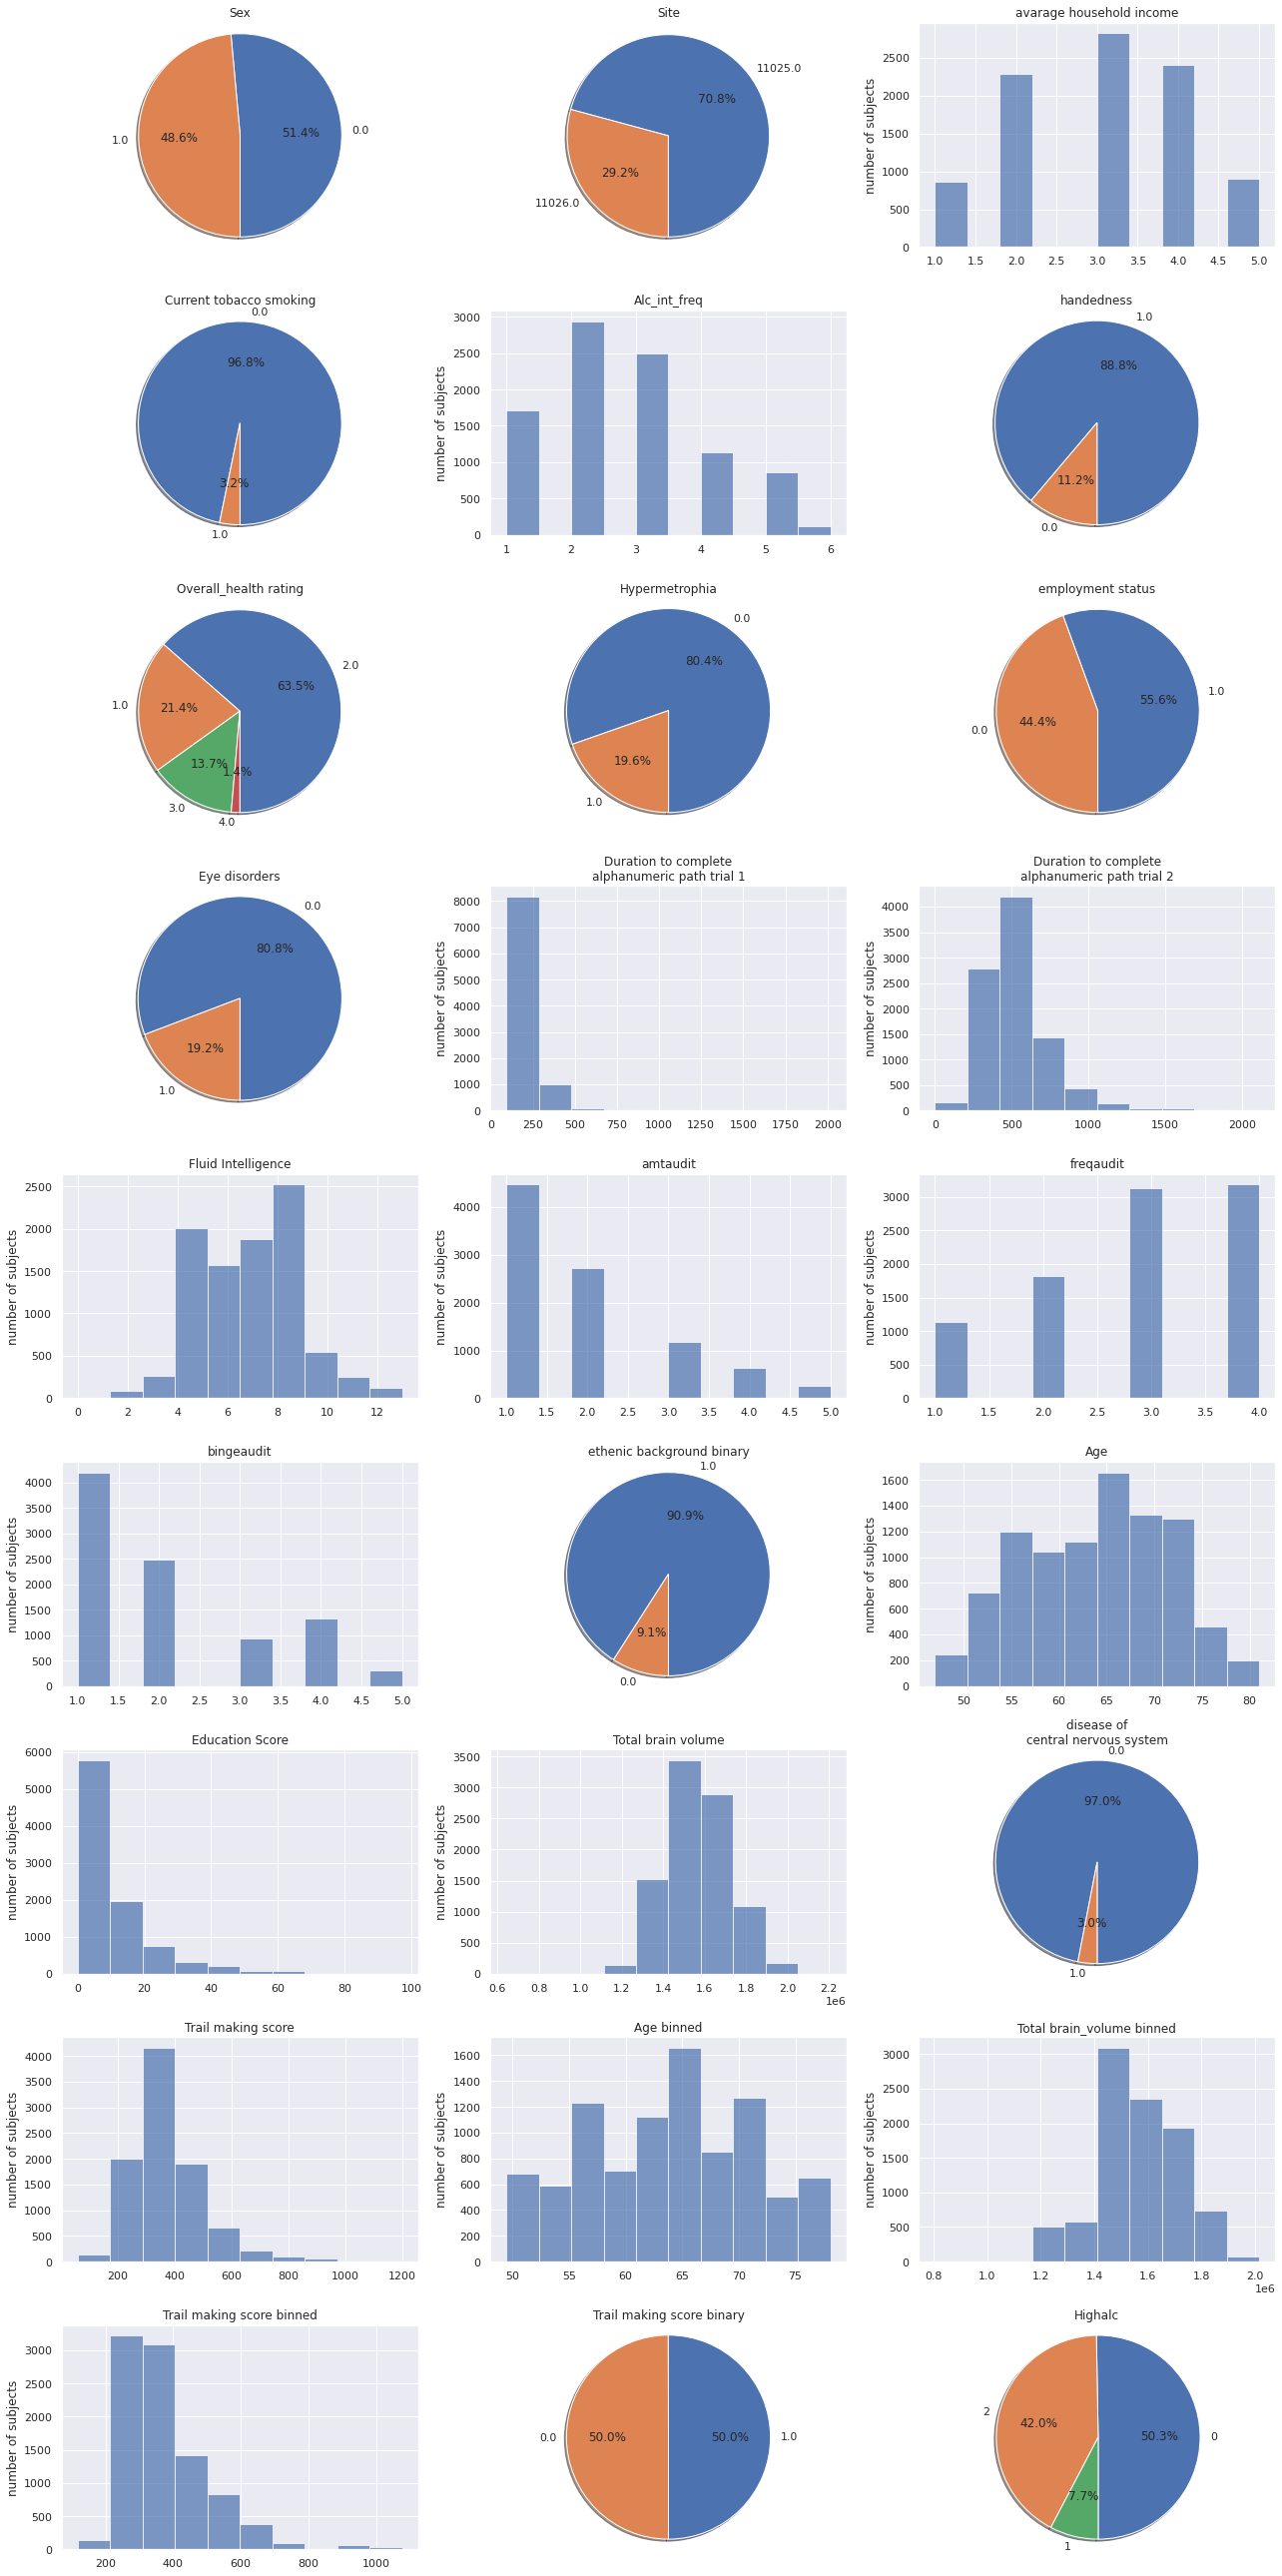

In [48]:
plot=dataset.plot_metadata(df)

In [47]:
dataset.add_var_to_h5(df, 'Sex', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Age', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Alc_int_freq', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Total_brain_volume', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Site', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Education_Score', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Fluid_Intelligence', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Current_tobacco_smoking', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Hypermetrophia', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Eye_disorders', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'trail_making_avg_duration', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'trail_making_avg_duration_binned', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'trail_making_avg_duration_binary', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Age_binned', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Total_brain_volume_binned', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Highalc', typ='lbl', binarize=True, class0=0, class1=2, viz=False)
dataset.add_var_to_h5(df, 'handedness', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'ethenic_background_binary', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'employment_status', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'avarage_household_income', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'number_of_household_integrants', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Overall_health_rating', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'disease_of_central_nervous_system', typ='lbl', viz=False)

,sex,age,alc_int_freq,total_brain_volume,site,education_score,fluid_intelligence,current_tobacco_smoking,hypermetrophia,eye_disorders,...,age_binned,total_brain_volume_binned,highalc,handedness,ethenic_background_binary,employment_status,avarage_household_income,number_of_household_integrants,overall_health_rating,disease_of_central_nervous_system
subjectID,,,,,,,,,,,,,,,,,,,,,
1000014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5824877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5838702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5846234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
dataset.prepare_X(mri_col='path_T1_MNI')

n=8364 after dropping subjects with NaN


In [19]:
dataset.save_h5(filename_prefix="confounds_tasks_8364k_train_bis", mri_kwargs={'z_factor':(0.525)})

In [49]:
#We create holdout in the same file because we need the decision trees for discretizating for the holdout
dataset = UKBB2020()

total subjects in df: 40682


In [50]:
df = dataset.get_metadata(predefined=[], cols = ["31-0.0", #sex
                                                '54-2.0', #assestment center
                                                 '21003-2.0', #age
                                                 '1707-0.0',#handedness
                                                 '21000-0.0',#ethenic background binary 
                                                 '6142-2.0', #current employment status
                                                '738-2.0',#avarage household total income after tax
                                                 "709-2.0", #Household size 
                                                 '2178-2.0', #Overall health rating
                                                 '26521-2.0', #total brain volume
                                                 "1558-2.0",#Alc int freq
                                                 "26414-0.0", #Education Score
                                                 "20016-2.0", #Fluid Intelligence
                                                 "1239-2.0", #Actual Tobacco smoking
                                                 "6350-2.0", #Duration to complete alphanumeric path trial 1
                                                 "6348-2.0", #Duration to complete alphanumeric path trial 2
                                                 "5832-2.0", #Which eye has hypermetrophia
                                                 "20414-0.0","20403-0.0","20416-0.0",  # AUDIT
                                                 "6148-2.0", #Eye problem/disorders
                                                ],split='holdout', rename_cols=False) 

loaded following columns:
 {'31-0.0': 'Sex (s0.0)', '54-2.0': 'UK Biobank assessment centre', '21003-2.0': 'Age when attended assessment centre', '1707-0.0': 'Handedness (chirality/laterality) (s0.0)', '21000-0.0': 'Ethnic background (s0.0)', '6142-2.0': 'Current employment status', '738-2.0': 'Average total household income before tax', '709-2.0': 'Number in household', '2178-2.0': 'Overall health rating', '26521-2.0': 'Volume of EstimatedTotalIntraCranial (whole brain)', '1558-2.0': 'Alcohol intake frequency.', '26414-0.0': 'Education score (England) (s0.0)', '20016-2.0': 'Fluid intelligence score', '1239-2.0': 'Current tobacco smoking', '6350-2.0': 'Duration to complete alphanumeric path (trail #2)', '6348-2.0': 'Duration to complete numeric path (trail #1)', '5832-2.0': 'Which eye(s) affected by hypermetropia (long sight)', '20414-0.0': 'Frequency of drinking alcohol (s0.0)', '20403-0.0': 'Amount of alcohol drunk on a typical drinking day (s0.0)', '20416-0.0': 'Frequency of consumi

In [51]:
#Adding central nervous system diseases as a column
dficd = dataset.get_metadata(predefined=['icd'], cols=[], print_cols=False, split='holdout', rename_cols=False)
df['disease_of_central_nervous_system'] =  dficd.apply(lambda row: row.astype(str).str.contains('G(?!50|51|52|53|54|55|56|57|70|71|72|73)[0-9][0-9]').any(), axis=1)
df['disease_of_central_nervous_system'] = df['disease_of_central_nervous_system'].astype(float)

skipping 30593/40682 subjects not belonging to holdout split


In [52]:
#Current employment status binary to retired or not
df['6142-2.0'] = df['6142-2.0'].replace(['-3.0','-1.0'],np.nan)
df['6142-2.0'] = df['6142-2.0'].apply(lambda x: 1.0 if x == '2.0' else 0.0) #Retired is 1.0

#Household size "709-2.0" eliminate outliers
df = df[df["709-2.0"] < 7.0]
df = df[df["709-2.0"] > 0.0]

#Index of multiple depravation .astype(float)
#df['26410-0.0'] = df['26410-0.0'].apply(lambda x: 1.0 if x > 42 else 0.0)

#Overall health rating turn missing values to np.nan 1	Excellent,2	Good,3	Fair,4	Poor
df['2178-2.0'] = df['2178-2.0'].replace(['-3.0','-1.0'],np.nan)

#Avarage income turn missing values to np.nan
df['738-2.0'] = df['738-2.0'].replace(['-3.0','-1.0'],np.nan)

#ethnic background binary British or not british
df['21000-0.0'] = df['21000-0.0'].replace('-3.0',np.nan)
df['21000-0.0'] = df['21000-0.0'].apply(lambda x: 1.0 if x == '1001.0' else 0.0) #british is 1.0
  
 #handedness turn: no available to np.nan and turn binary to right handed or not right handed
df['1707-0.0']= df['1707-0.0'].replace('-3.0',np.nan)
df['1707-0.0'] = df['1707-0.0'].apply(lambda x: 1.0 if x == '1.0' else 0.0)

  #eyeproblems #Yes or no
df['6148-2.0']= df['6148-2.0'].replace(['1.0','2.0','3.0','4.0','5.0','6.0'],'1.0')
df['6148-2.0']= df['6148-2.0'].replace(['-7.0'],'0.0')
df['6148-2.0']= df['6148-2.0'].replace(['-3.0','-1.0'],np.nan)
 
  #hypermetrophia
df['5832-2.0'] = df['5832-2.0'].astype(float)
df['5832-2.0'].fillna(0.0, inplace=True) #add people without hypermetrophia with 0.0
df['5832-2.0'] = df['5832-2.0'].apply(lambda x: 1.0 if x >= 1.0 else 0.0)

#Current_tobacco_smoking
df['1239-2.0']= df['1239-2.0'].replace(['1.0','2.0'],'1.0') #smokers
df['1239-2.0']= df['1239-2.0'].replace(['-3.0'],np.nan)

#Trail making avg duration
df["trail_making_avg_duration"]=(df["6350-2.0"] + df["6348-2.0"])/2
df = df[df["trail_making_avg_duration"] < 1200.0] #to remove outliers
df = df[df["trail_making_avg_duration"] > 1.0]

In [53]:
"""
df = df.rename(columns={'31-0.0' : 'Sex',
                        '21003-2.0' : 'Age',
                        "1558-2.0" :'Alc_int_freq' ,
                        '26521-2.0': 'Total_brain_volume',
                        '54-2.0': 'Site',
                        "26414-0.0":'Education_Score',
                        "20016-2.0" :'Fluid_Intelligence',
                        "6350-2.0" : 'Duration to complete alphanumeric path trial 2',
                        "6348-2.0" : 'Duration to complete alphanumeric path trial 1',
                        "5832-2.0" : 'Hypermetrophia',
                        "6148-2.0" : 'Eye_disorders',
                        '20414-0.0': 'freqaudit', 
                         '20403-0.0': 'amtaudit', 
                         '20416-0.0': 'bingeaudit',
                        '1707-0.0' : 'handedness',
                         '21000-0.0' : 'ethenic_background_binary' ,
                         '6142-2.0' : 'employment_status',
                          '738-2.0' : 'avarage_household_income',
                         "709-2.0" : 'number_of_household_integrants' ,
                         '2178-2.0' : 'Overall_health_rating',
                         '26410-0.0': 'index_of_multiple_depravation',
                        "1239-2.0" : 'Current_tobacco_smoking',
                       })
"""
                       

'\ndf = df.rename(columns={\'31-0.0\' : \'Sex\',\n                        \'21003-2.0\' : \'Age\',\n                        "1558-2.0" :\'Alc_int_freq\' ,\n                        \'26521-2.0\': \'Total_brain_volume\',\n                        \'54-2.0\': \'Site\',\n                        "26414-0.0":\'Education_Score\',\n                        "20016-2.0" :\'Fluid_Intelligence\',\n                        "6350-2.0" : \'Duration to complete alphanumeric path trial 2\',\n                        "6348-2.0" : \'Duration to complete alphanumeric path trial 1\',\n                        "5832-2.0" : \'Hypermetrophia\',\n                        "6148-2.0" : \'Eye_disorders\',\n                        \'20414-0.0\': \'freqaudit\', \n                         \'20403-0.0\': \'amtaudit\', \n                         \'20416-0.0\': \'bingeaudit\',\n                        \'1707-0.0\' : \'handedness\',\n                         \'21000-0.0\' : \'ethenic_background_binary\' ,\n                   

In [54]:
df = df.rename(columns={'31-0.0' : 'Sex',
                        '21003-2.0' : 'Age',
                        "1558-2.0" :'Alc_int_freq' ,
                        '26521-2.0': 'Total brain volume',
                        '54-2.0': 'Site',
                        "26414-0.0":'Education Score',
                        "20016-2.0" :'Fluid Intelligence',
                        "6350-2.0" : 'Duration to complete alphanumeric path trial 2',
                        "6348-2.0" : 'Duration to complete alphanumeric path trial 1',
                        "5832-2.0" : 'Hypermetrophia',
                        "6148-2.0" : 'Eye disorders',
                        '20414-0.0': 'freqaudit', 
                         '20403-0.0': 'amtaudit', 
                         '20416-0.0': 'bingeaudit',
                        '1707-0.0' : 'handedness',
                         '21000-0.0' : 'ethenic background binary' ,
                         '6142-2.0' : 'employment status',
                          '738-2.0' : 'avarage household income',
                         "709-2.0" : 'number of household integrants' ,
                         '2178-2.0' : 'Overall_health rating',
                        "1239-2.0" : 'Current tobacco smoking',
                        "disease_of_central_nervous_system" : 'disease of central nervous system',
                        'trail_making_avg_duration':'Trail making score'
                       })

df = df.drop(['number of household integrants'], axis=1)

In [55]:
df = df.dropna()

In [56]:
#discretasing age
df_transformedage= discage.transform(df)

#discretasing brain volume
df_transformedbrain= discbrainvol.transform(df)

#discretasing trail making
df_transformedtrail= disctrail.transform(df)

In [57]:
"""
#adding discretized variables
df['Age_binned'] = df_transformedage['Age']
df['Total_brain_volume_binned'] = df_transformedbrain['Total_brain_volume']
df["trail_making_avg_duration_binned"] = df_transformedtrail["trail_making_avg_duration"]
df["trail_making_avg_duration_binary"] = df["trail_making_avg_duration"].apply(lambda x: 1.0 if x >= median else 0.0)
"""
#adding discretized variables
df['Age binned'] = df_transformedage['Age']
df['Total brain_volume binned'] = df_transformedbrain['Total brain volume']
df["Trail making score binned"] = df_transformedtrail["Trail making score"]
df["Trail making score binary"] = df["Trail making score"].apply(lambda x: 1.0 if x >= median else 0.0)

In [58]:
# change the dtype to float
for c in df.columns:
    if df[c].dtype.name == 'category':
        for cat in df[c].cat.categories:
            # give invalid categories the same value (-1.0)
            if float(cat) < 0.0:
                df[c]= df[c].replace(cat, np.NaN)
    
    df[c] = df[c].astype(float)
# apply the AUDIT skip rules to 'amtaudit' and 'bingeaudit'
df.loc[df['freqaudit']==0, 'amtaudit'] = 1.0
df.loc[df['freqaudit']==0, 'bingeaudit'] = 1.0

def get_alc_lvl(row):
    # row = row.fillna(0)
    if (row['Alc_int_freq']<=3 and (row['amtaudit']+row['bingeaudit'])>=4):
        return 2 #True
    elif row[['Alc_int_freq', 'freqaudit']].isna().any() or ( # also exclude very high value in any of the variables
        row['amtaudit']>3 or row['bingeaudit']>3 or row['Alc_int_freq']<=1): # (row['freq']<=3 and (row['amtaudit']+row['bingeaudit'])<3) or 
        return 1 #np.NaN
    else:
        return 0 #False

    #get highalc class
df['Highalc'] = df.apply(lambda row: get_alc_lvl(row), axis=1)

In [59]:
#We now convert the 6 bins of Alc freq to 3 
df['Alc_int_freq']= df['Alc_int_freq'].replace(['1.0','2.0'],'2.0') #3 to 4 week/daily -> frecuent drinkers
df['Alc_int_freq']= df['Alc_int_freq'].replace(['3.0','4.0'],'1.0') #One to 3 month/ one or two week -> ocassional drinkers
df['Alc_int_freq']= df['Alc_int_freq'].replace(['5.0','6.0'],'0.0') #Rarely or never
df['Alc_int_freq']= df['Alc_int_freq'].replace(['-3.0'],np.nan) #Not answered

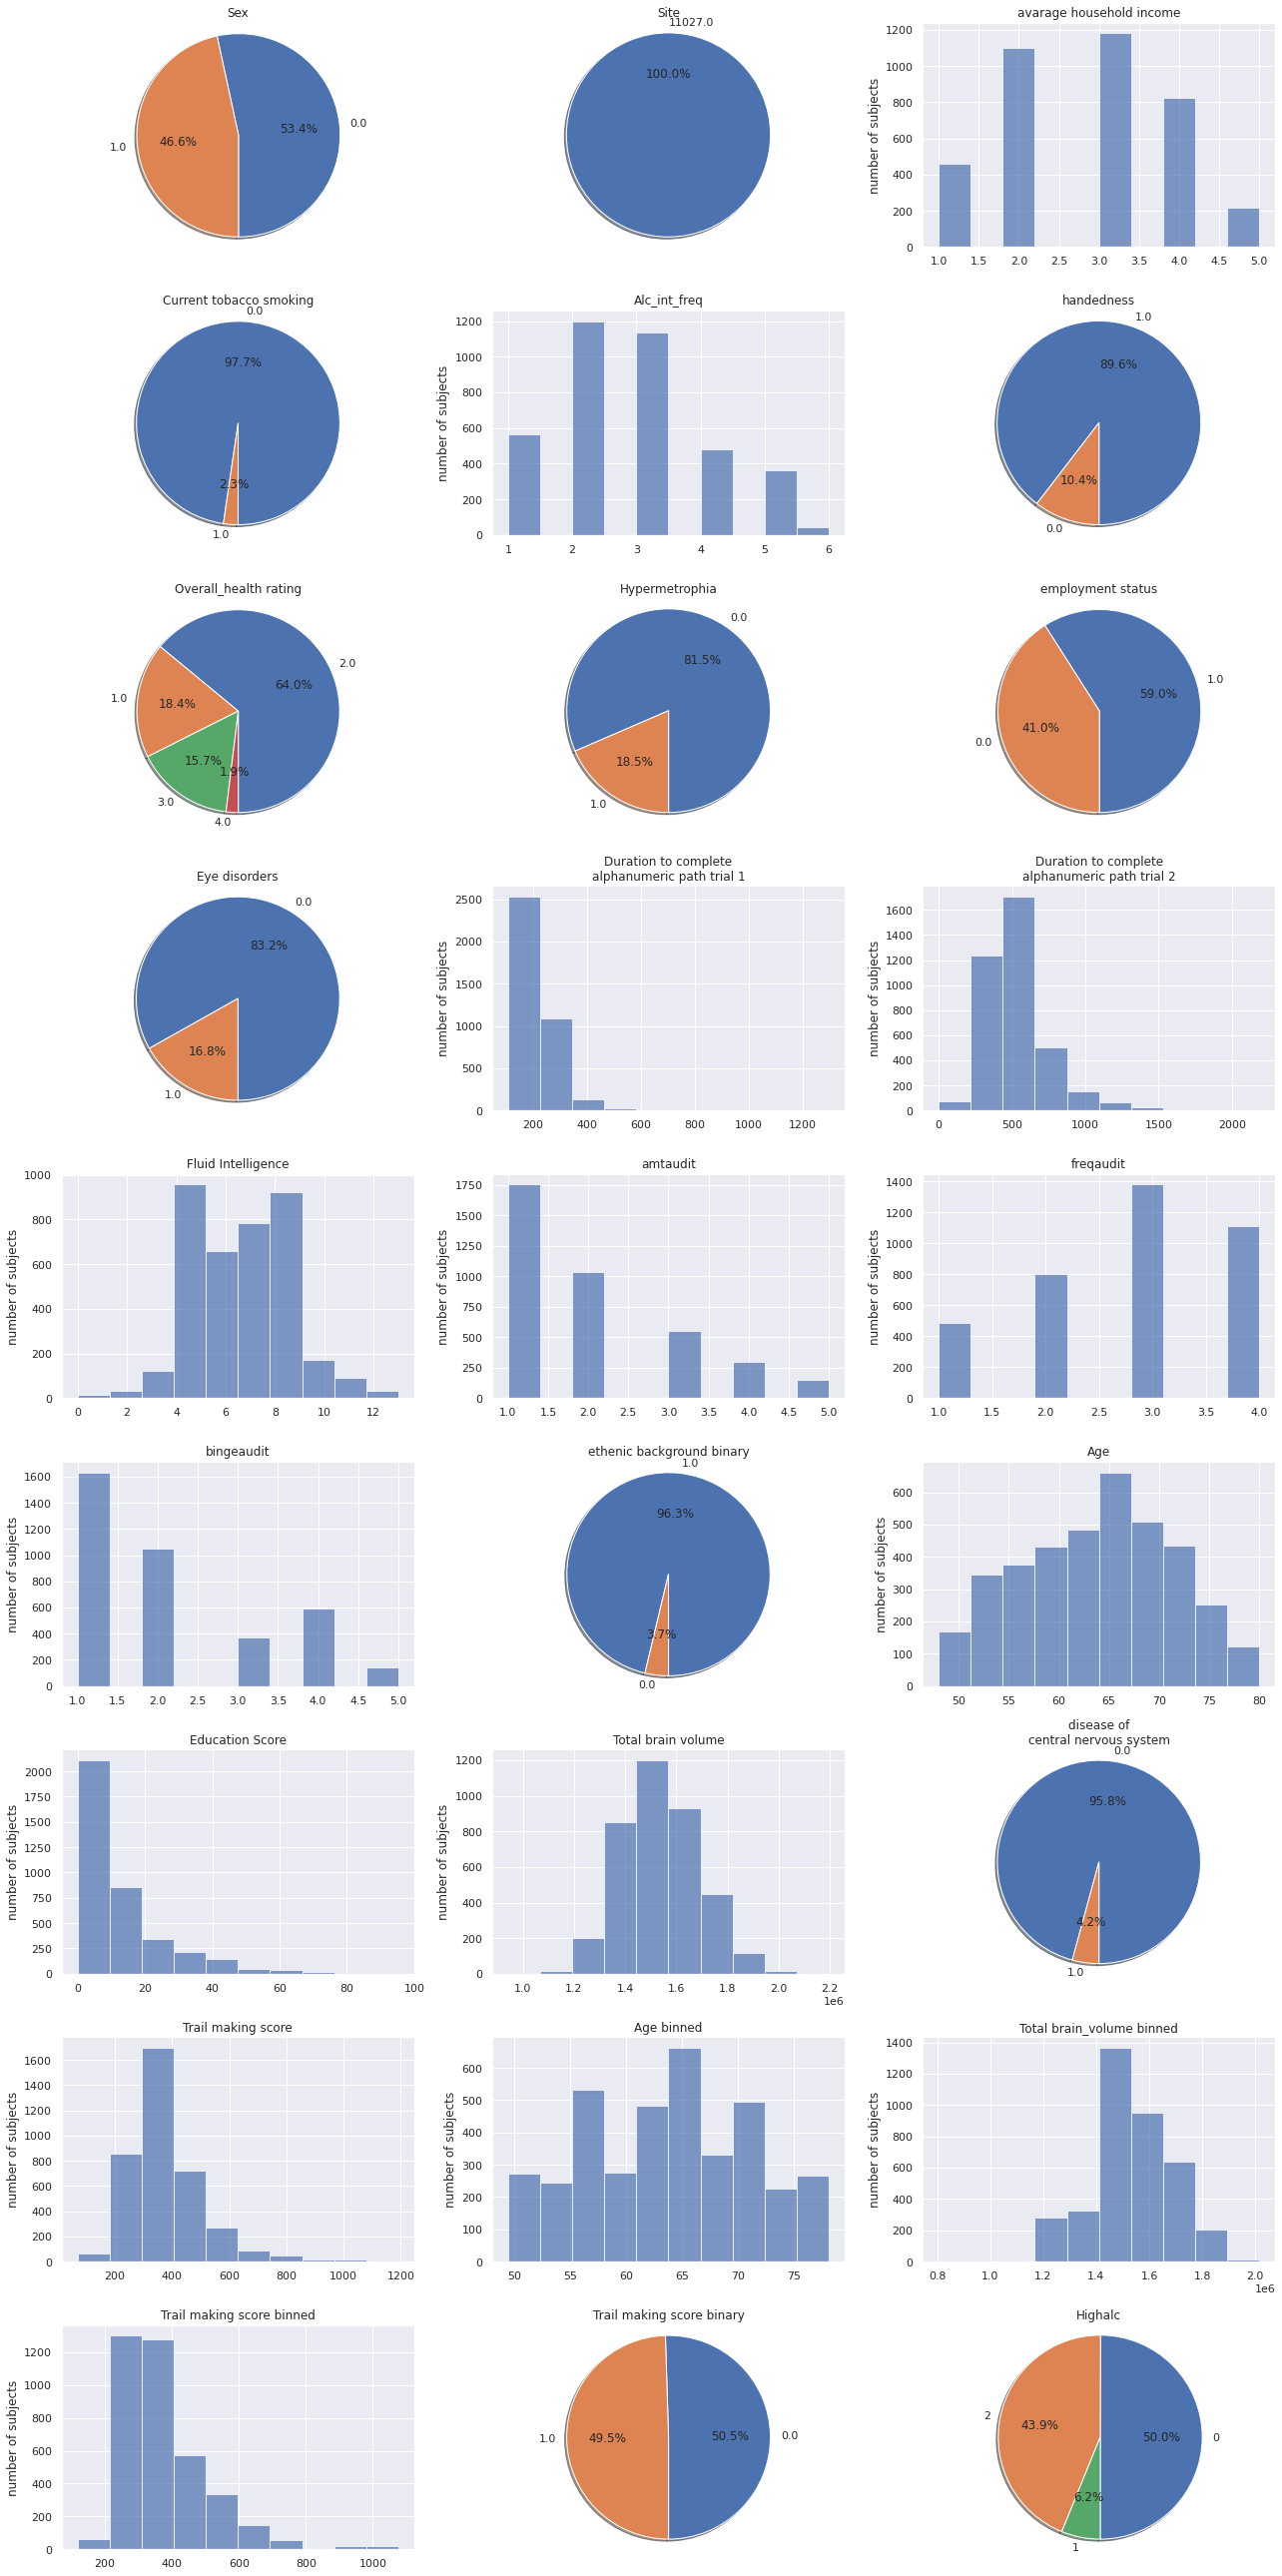

In [60]:
dataset.plot_metadata(df)

In [61]:
dataset.add_var_to_h5(df, 'Sex', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Age', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Alc_int_freq', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Total_brain_volume', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Site', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Education_Score', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Fluid_Intelligence', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Current_tobacco_smoking', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Hypermetrophia', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Eye_disorders', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'trail_making_avg_duration', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'trail_making_avg_duration_binned', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'trail_making_avg_duration_binary', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Age_binned', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Total_brain_volume_binned', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Highalc', typ='lbl', binarize=True, class0=0, class1=2, viz=False)
dataset.add_var_to_h5(df, 'handedness', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'ethenic_background_binary', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'employment_status', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'avarage_household_income', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'number_of_household_integrants', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'Overall_health_rating', typ='lbl', viz=False)
dataset.add_var_to_h5(df, 'disease_of_central_nervous_system', typ='lbl', viz=False)

,sex,age,alc_int_freq,total_brain_volume,site,education_score,fluid_intelligence,current_tobacco_smoking,hypermetrophia,eye_disorders,...,age_binned,total_brain_volume_binned,highalc,handedness,ethenic_background_binary,employment_status,avarage_household_income,number_of_household_integrants,overall_health_rating,disease_of_central_nervous_system
subjectID,,,,,,,,,,,,,,,,,,,,,
1000014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5824877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5838702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5846234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
dataset.prepare_X(mri_col='path_T1_MNI')

n=3460 after dropping subjects with NaN


In [ ]:
dataset.save_h5(filename_prefix="confounds_tasks_3460k_holdout_bis", mri_kwargs={'z_factor':(0.525)})

In [82]:
!jupyter nbconvert --to script Finalh5filecreator.ipynb

[NbConvertApp] Converting notebook Finalh5filecreator.ipynb to script
[NbConvertApp] Writing 21858 bytes to Finalh5filecreator.py
